In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import MinMaxScaler

SILVER_PATH = '/Users/olievortex/lakehouse/default/Files/silver/igra2/gph20s10k'
batch_size = 32
epochs = 15
grid_count = 40
max_neurons = 200

In [12]:
def load_dataset():
    df = pd.read_csv(f'{SILVER_PATH}/USM00072649-data-gph20s10k.csv')

    # Remove irrelevant data
    X = df.drop(['id', 'effective_date', 'hour'], axis=1)
    
    # Scale the X dataset
    ss = MinMaxScaler() 
    X = ss.fit_transform(X)
   
    return X, ss

In [13]:
dataset, columns = load_dataset()
dataset = torch.from_numpy(dataset).float()

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = batch_size,
                                     shuffle = True)

In [14]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.num_features = num_features
          
    def scenario_2d(self, l2: int, l1: int):
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.num_features, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l1)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, self.num_features),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [15]:
model = AutoEncoder(dataset.size()[1])
loss_function = torch.nn.MSELoss()

In [16]:
def grid_search_2d():
    output = []

    coly = np.linspace(5, max_neurons, grid_count, dtype=int)

    X, Y = np.meshgrid(coly, coly)

    for l1, l2 in [(x, y) for y in coly for x in coly]:
        print(f"Layers: ({l1}, {l2})", end="")
        
        if l1 > l2:
            output.append(0)
            print(", illogical")
            continue
    
        if (l1 + l2) > max_neurons:
            output.append(0)
            print(", too big")
            continue

        if l1 > 50:
            output.append(0)
            print(", too loose")
            continue

        model.scenario_2d(l2, l1)
        optimizer = torch.optim.Adam(model.parameters())

        for _ in range(epochs):
            cost = 0

            for batch in loader:
                reconstructed = model(batch)

                loss = loss_function(reconstructed, batch)
                cost += loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f", {cost / len(loader):.5f}", end="")

        print()
        output.append(float(f"{cost / len(loader):.5f}"))
    
    return X, Y, output

X, Y, output = grid_search_2d()

Layers: (5, 5), 0.03033, 0.01299, 0.01029, 0.00899, 0.00843, 0.00816, 0.00801, 0.00793, 0.00787, 0.00778, 0.00769, 0.00733, 0.00680, 0.00666, 0.00662
Layers: (10, 5), illogical
Layers: (15, 5), illogical
Layers: (20, 5), illogical
Layers: (25, 5), illogical
Layers: (30, 5), illogical
Layers: (35, 5), illogical
Layers: (40, 5), illogical
Layers: (45, 5), illogical
Layers: (50, 5), illogical
Layers: (55, 5), illogical
Layers: (60, 5), illogical
Layers: (65, 5), illogical
Layers: (70, 5), illogical
Layers: (75, 5), illogical
Layers: (80, 5), illogical
Layers: (85, 5), illogical
Layers: (90, 5), illogical
Layers: (95, 5), illogical
Layers: (100, 5), illogical
Layers: (105, 5), illogical
Layers: (110, 5), illogical
Layers: (115, 5), illogical
Layers: (120, 5), illogical
Layers: (125, 5), illogical
Layers: (130, 5), illogical
Layers: (135, 5), illogical
Layers: (140, 5), illogical
Layers: (145, 5), illogical
Layers: (150, 5), illogical
Layers: (155, 5), illogical
Layers: (160, 5), illogical


/var/folders/7x/y_0m3dbn3pl7shgklj8r717m0000gn/T/ipykernel_1557/3023120596.py:2: RuntimeWarning: divide by zero encountered in log
  Z = np.log(Z)


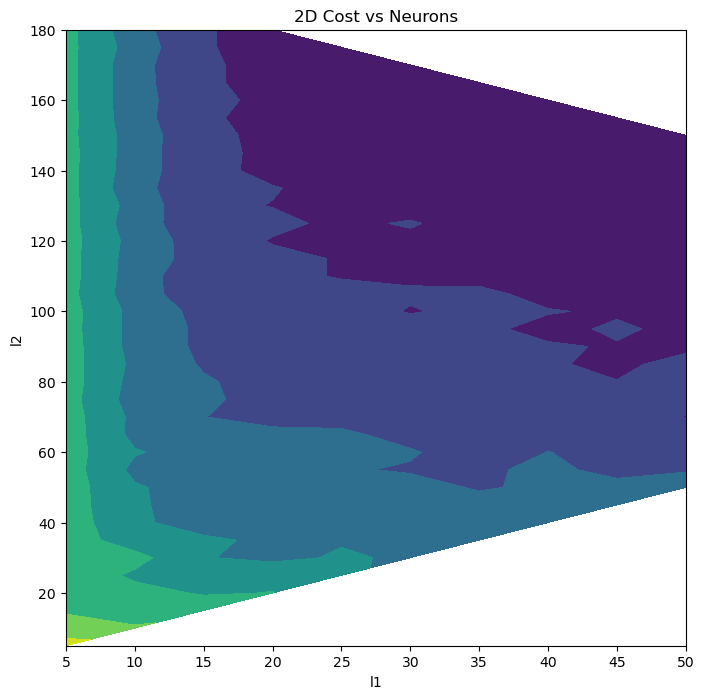

In [17]:
Z = np.reshape(output, (grid_count, grid_count))
Z = np.log(Z)
fig, ax = plt.subplots(figsize=(8, 8))

ax.title.set_text('2D Cost vs Neurons')
ax.contourf(X, Y, Z)
ax.set_xlabel('l1')
ax.set_ylabel('l2')
ax.set_xlim(5, 50)
ax.set_ylim(5, 180)
plt.show()